# Multi-Class Prediction of Cirrhosis Outcomes

Kaggle competition link: https://www.kaggle.com/competitions/playground-series-s3e26/data?select=train.csv



---



---



## Imports

In [1]:
! pip install kaggle

In [2]:
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.8 MB/s eta 0:00:00


In [3]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from catboost import CatBoostClassifier

from tqdm.notebook import tqdm

import optuna

## Uploads

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"acumfly","key":"2c1562e5f7ecf9c5bee3c58cba202660"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download --force playground-series-s3e26

  0% 0.00/350k [00:00<?, ?B/s]
100% 350k/350k [00:00<00:00, 66.3MB/s]


In [8]:
!unzip playground-series-s3e26.zip

Archive:  playground-series-s3e26.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [9]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Dataset overview

In [10]:
train_df.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [11]:
test_df.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,7906,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,7907,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,7908,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,7909,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


In [12]:
train_df.drop(['id'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
N_Days,7905.0,2030.173308,1094.233744,41.00,1230.00,1831.00,2689.00,4795.00
Age,7905.0,18373.146490,3679.958739,9598.00,15574.00,18713.00,20684.00,28650.00
Bilirubin,7905.0,2.594485,3.812960,0.30,0.70,1.10,3.00,28.00
Cholesterol,7905.0,350.561923,195.379344,120.00,248.00,298.00,390.00,1775.00
Albumin,7905.0,3.548323,0.346171,1.96,3.35,3.58,3.77,4.64
Copper,7905.0,83.902846,75.899266,4.00,39.00,63.00,102.00,588.00
Alk_Phos,7905.0,1816.745250,1903.750657,289.00,834.00,1181.00,1857.00,13862.40
SGOT,7905.0,114.604602,48.790945,26.35,75.95,108.50,137.95,457.25
Tryglicerides,7905.0,115.340164,52.530402,33.00,84.00,104.00,139.00,598.00
Platelets,7905.0,265.228969,87.465579,62.00,211.00,265.00,316.00,563.00


In [13]:
test_df.drop(['id'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
N_Days,5271.0,2038.696642,1086.843490,41.00,1234.00,1882.00,2692.00,4795.00
Age,5271.0,18497.756782,3583.898801,9598.00,15730.00,18806.00,20684.00,28650.00
Bilirubin,5271.0,2.600389,3.852395,0.30,0.70,1.10,3.00,28.00
Cholesterol,5271.0,352.486435,200.438989,120.00,248.00,299.00,390.00,1775.00
Albumin,5271.0,3.538071,0.354886,1.96,3.35,3.57,3.77,4.64
Copper,5271.0,84.701679,77.542064,4.00,39.00,65.00,102.00,588.00
Alk_Phos,5271.0,1811.233314,1935.351492,289.00,823.00,1142.00,1838.50,13862.40
SGOT,5271.0,113.587526,48.964789,26.35,75.00,106.95,137.95,457.25
Tryglicerides,5271.0,115.286094,52.602780,33.00,84.00,104.00,138.00,598.00
Platelets,5271.0,264.023715,87.584068,62.00,209.00,259.00,317.00,563.00


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

No missed values in both train and test datasets.

In [16]:
for c in train_df.columns:
   print("---- %s ---" % c)
   print(train_df[c].value_counts())


---- id ---
0       1
5280    1
5278    1
5277    1
5276    1
       ..
2631    1
2630    1
2629    1
2628    1
7904    1
Name: id, Length: 7905, dtype: int64
---- N_Days ---
1216    117
1434    105
769      83
3445     73
1765     64
       ... 
1870      1
2523      1
1214      1
3492      1
214       1
Name: N_Days, Length: 461, dtype: int64
---- Drug ---
Placebo            4010
D-penicillamine    3895
Name: Drug, dtype: int64
---- Age ---
22369    79
22388    71
20684    71
19060    70
16279    66
         ..
16939     1
13728     1
23111     1
13170     1
18628     1
Name: Age, Length: 391, dtype: int64
---- Sex ---
F    7336
M     569
Name: Sex, dtype: int64
---- Ascites ---
N    7525
Y     380
Name: Ascites, dtype: int64
---- Hepatomegaly ---
Y    4042
N    3863
Name: Hepatomegaly, dtype: int64
---- Spiders ---
N    5966
Y    1939
Name: Spiders, dtype: int64
---- Edema ---
N    7161
S     399
Y     345
Name: Edema, dtype: int64
---- Bilirubin ---
0.6     847
0.7     653
0.8     

In [17]:
cat_features = ['Drug', 'Sex', 'Stage', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
num_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
target = 'Status'

Feature description:

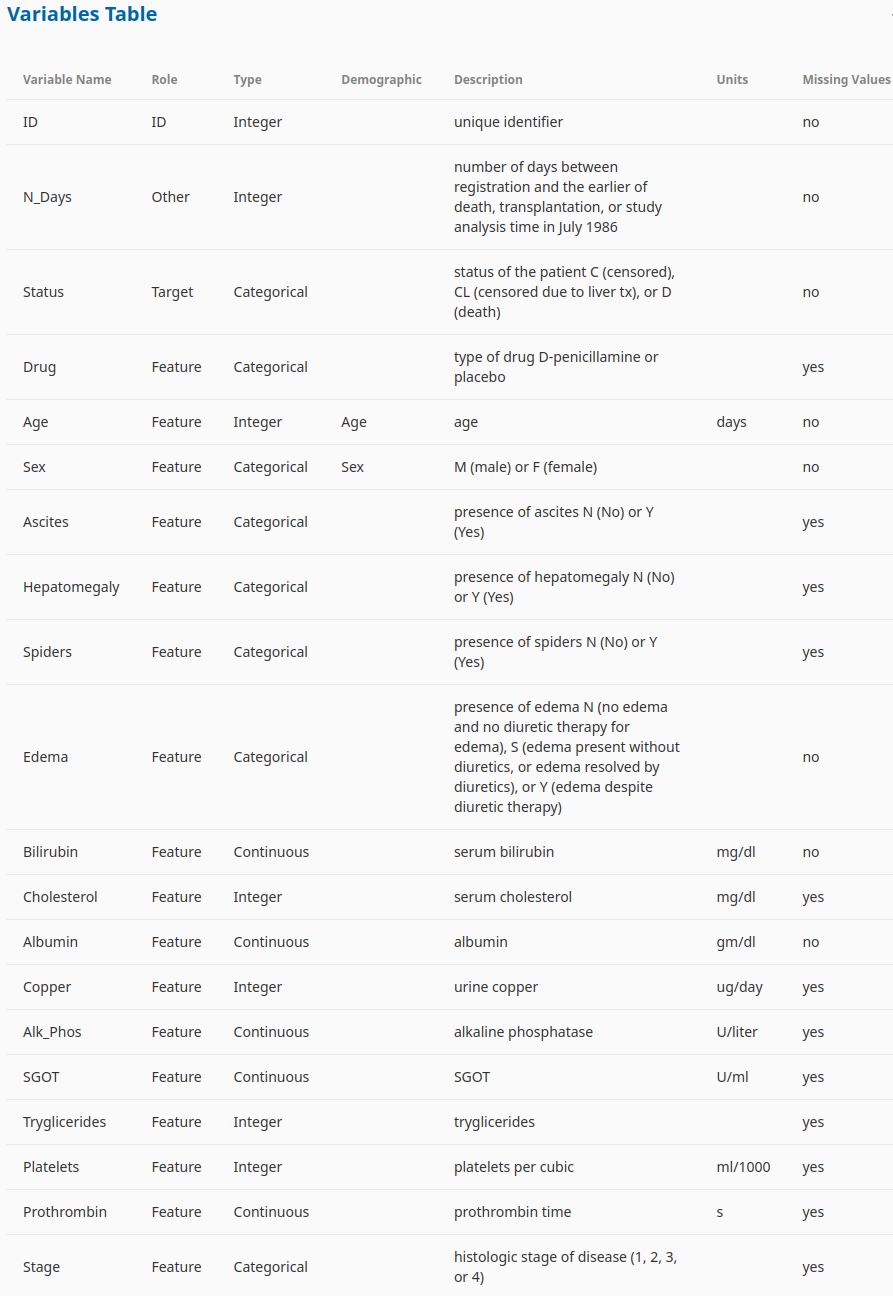

## EDA

### Distribution of numeric features:

In [18]:
fig, axes = plt.subplots(11, 2, figsize=(15, 40), dpi=300)


for ind, col in enumerate(train_df[num_features]):
  plt.subplot(11, 2, ind*2+1)
  sns.histplot(data=train_df, hue=target, x=col, bins=15, kde=True)
  plt.gca().set_title(col)

  plt.subplot(11, 2, ind*2+2)
  sns.boxplot(data=train_df, hue=target, x=col, orient='h', color='lightblue')
  plt.gca().set_title(col)

fig.tight_layout()
plt.show()

<ipython-input-18-db6e7150022b>:10: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightblue'` for the same effect.

  sns.boxplot(data=train_df, hue=target, x=col, orient='h', color='lightblue')
<ipython-input-18-db6e7150022b>:10: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightblue'` for the same effect.

  sns.boxplot(data=train_df, hue=target, x=col, orient='h', color='lightblue')
<ipython-input-18-db6e7150022b>:10: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightblue'` for the same effect.

  sns.boxplot(data=train_df, hue=target, x=col, orient='h', color='lightblue')
<ipython-input-18-db6e7150022b>:10: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightblue'` for the same effe

*Conclusions:*


*   The less the number of days between registration and the earlier death/transplantation/study analysis, the higher the death rate.
*   High levels of prothrombin is followed by higher risk of death.
*   Most distributions are close to normal.


### Distribution of categorical features:

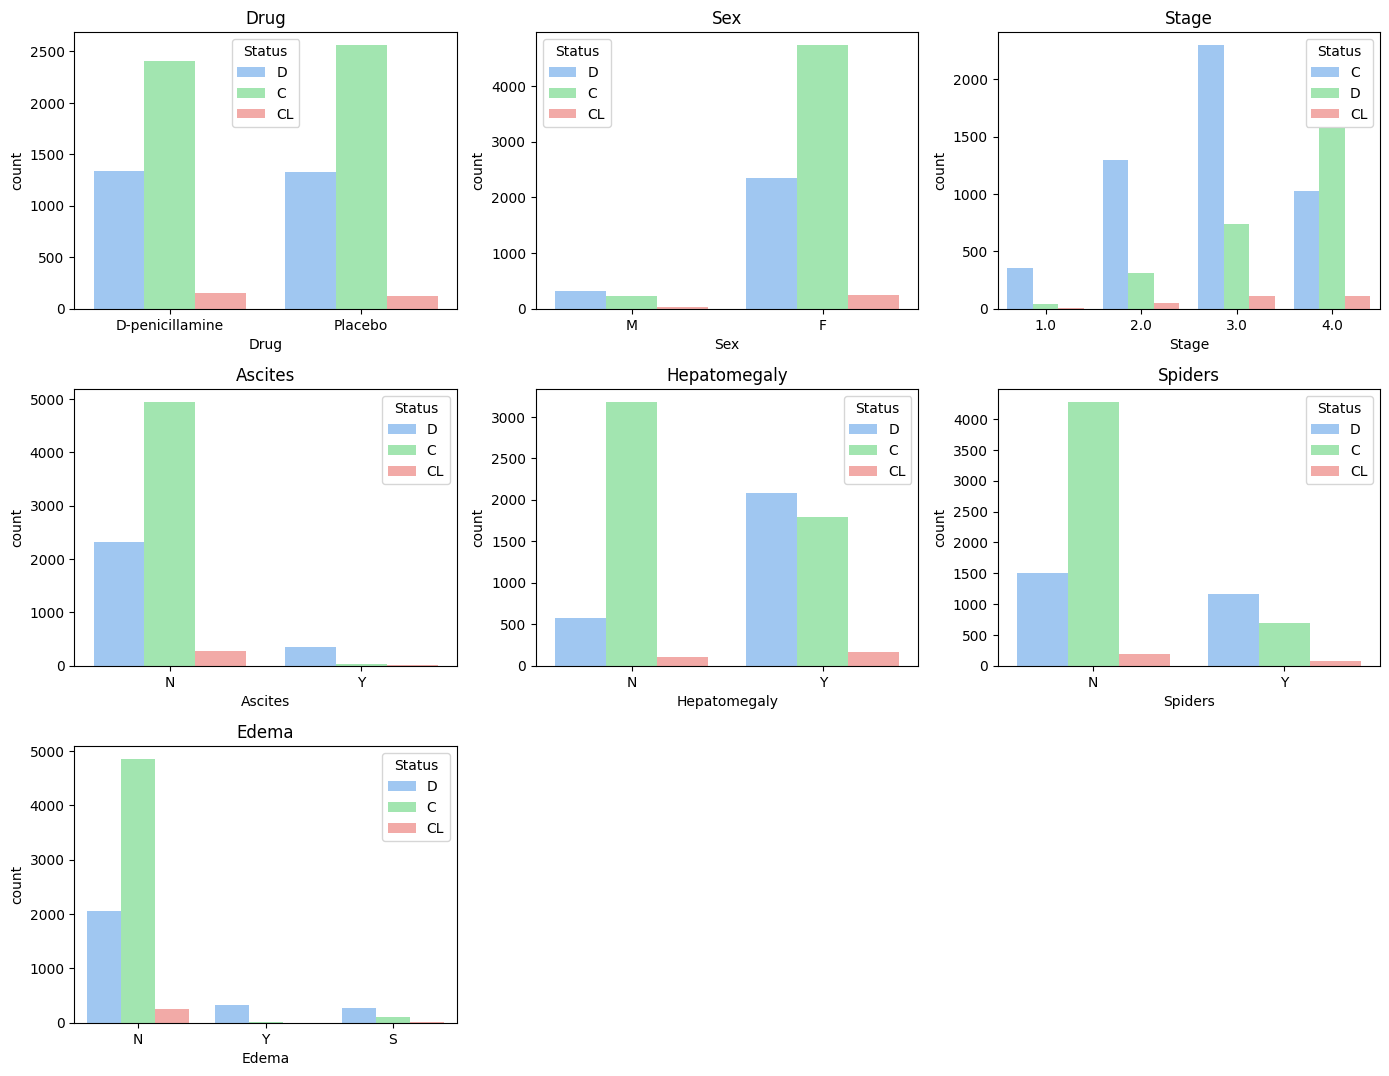

In [19]:
plt.figure(figsize=(14, len(cat_features) * 2))
for i, col in enumerate(cat_features):
    plt.style.use('seaborn-v0_8-pastel')
    plt.subplot(len(cat_features) // 2 + 1, 3, i + 1)
    sns.countplot(data=train_df, x=col, hue=target)
    plt.title(col)
    plt.tight_layout()

*Conclusions:*

*   Mortality from cirrhosis is higher among women.
*   The higher the stage of the disease, the higher the death rate.
*   People with hepatomegaly have a higher mortality rate.
*   Новый пункт





## Data preprocessing

In [20]:
train = train_df.copy()
test = test_df.copy()

In [21]:
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [22]:
# Convert 'Age' from days to years
train['Age'] = (train_df['Age'] / 365).astype(int)
test['Age'] = (test_df['Age'] / 365).astype(int)
# Convert 'Drug' to binary
train['Drug'] = train_df['Drug'].map({'D-penicillamine':1, 'Placebo':0})
test['Drug'] = test_df['Drug'].map({'D-penicillamine':1, 'Placebo':0})

yes_no_features = ['Ascites', 'Hepatomegaly', 'Spiders']
# Convert 'Y', 'N' to binary:
for feat in yes_no_features:
  train[feat] = train_df[feat].map({'Y': 1, 'N': 0})
  test[feat] = test_df[feat].map({'Y': 1, 'N': 0})

# Categorical features transformation
train['Stage'] = train_df['Stage'].astype(int)
test['Stage'] = test_df['Stage'].astype(int)
train = pd.get_dummies(data=train, columns=['Sex', 'Stage', 'Edema'])
test = pd.get_dummies(data=test, columns=['Sex', 'Stage', 'Edema'])

# Encode the target
train['Status'] = train_df['Status'].map({'D':0, 'C':1, 'CL':2})


In [23]:
cat_features = list(set(cat_features).difference(set(['Sex', 'Stage', 'Edema'])))
cat_features.extend(['Sex_F', 'Sex_M', 'Stage_1', 'Stage_2',	'Stage_3',	'Stage_4',	'Edema_N', 'Edema_S',	'Edema_Y'])
cat_features

['Hepatomegaly',
 'Ascites',
 'Drug',
 'Spiders',
 'Sex_F',
 'Sex_M',
 'Stage_1',
 'Stage_2',
 'Stage_3',
 'Stage_4',
 'Edema_N',
 'Edema_S',
 'Edema_Y']

In [24]:
train.head()

,id,N_Days,Drug,Age,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,...,Status,Sex_F,Sex_M,Stage_1,Stage_2,Stage_3,Stage_4,Edema_N,Edema_S,Edema_Y
0,0,999,1,58,0,0,0,2.3,316.0,3.35,...,0,0,1,0,0,1,0,1,0,0
1,1,2574,0,52,0,0,0,0.9,364.0,3.54,...,1,1,0,0,0,1,0,1,0,0
2,2,3428,0,37,0,1,1,3.3,299.0,3.55,...,0,1,0,0,0,0,1,0,0,1
3,3,2576,0,50,0,0,0,0.6,256.0,3.50,...,1,1,0,0,0,1,0,1,0,0
4,4,788,0,45,0,1,0,1.1,346.0,3.65,...,1,1,0,0,0,0,1,1,0,0


## Feature Selection & Parameter tuning

In [25]:
X = train.drop(columns=['id', 'Status'])
y = train.Status

seed = 42

In [26]:
categorical_features_indices = np.where(X.dtypes != float)[0]
categorical_features_indices

array([ 0,  1,  2,  3,  4,  5, 15, 16, 17, 18, 19, 20, 21, 22, 23])

Let's select features using RFECV (Recursive Feature Elimination with Cross-Validation)

### Logistic Regression

In [28]:
feat_logreg = Pipeline([
   ('power_transformer', PowerTransformer()), #for normalization
   ('logistic_regression', LogisticRegression(multi_class='ovr', max_iter=1000, random_state=seed))
])

feat_logreg.named_steps['power_transformer'].fit(X)
feat_logreg.named_steps['logistic_regression'].fit(X, y)

rfe_logreg = RFECV(estimator=feat_logreg.named_steps['logistic_regression'], min_features_to_select=1, step=1, n_jobs=-1, verbose=1)
rfe_logreg.fit(X, y)

logreg_feats = X.columns[rfe_logreg.support_].values
print("Feature Selection: ", logreg_feats.tolist())


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 24 features.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Feature Selection:  ['N_Days', 'Drug', 'Age', 'Ascites', 'Hepatomegaly', 'Spiders', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Sex_F', 'Sex_M', 'Stage_1', 'Stage_2', 'Stage_3', 'Stage_4', 'Edema_N', 'Edema_S', 'Edema_Y']


In [ ]:
# results are better without normalization

# pt = PowerTransformer()
# X_transformed = pt.fit_transform(X)
# X_transformed = pd.DataFrame(X_transformed, columns=X.columns)

In [29]:
def objective(trial):
    train_x , test_x , train_y , test_y = train_test_split(X[logreg_feats] , y , \
            test_size = 0.25 , random_state = seed, stratify = y)
    params = {
        'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_loguniform("C", 1e-2, 1),
       'fit_intercept' : trial.suggest_categorical('fit_intercept' , [True, False]),
       'solver' : trial.suggest_categorical('solver' , ['lbfgs','liblinear']),
        "n_jobs" : -1
    }
    model1 = LogisticRegression(multi_class='ovr', **params, random_state = 45)
    model1.fit(train_x , train_y)
    y_predlr1 = model1.predict_proba(test_x)
    model2 = LogisticRegression(**params, random_state = 45)
    model2.fit(train_x , train_y)
    y_predlr2 = model2.predict_proba(test_x)
    y_predlr = (y_predlr1 + y_predlr2) / 2
    ll = log_loss(test_y , y_predlr)
    return ll

In [30]:
%%time
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100, n_jobs=-1, show_progress_bar=True)
print(f'Number of trials: {len(study.trials)}')
print(f'Best trial: {study.best_trial.params}')
print('Best value:' , study.best_value)

[I 2024-01-18 11:31:08,280] A new study created in memory with name: no-name-2cf17952-6f83-4f7d-b499-1fe5f9400cba


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'libl

[I 2024-01-18 11:31:10,073] Trial 0 finished with value: 0.5439789068206677 and parameters: {'tol': 0.0007612520728162545, 'C': 0.8190084488196944, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 0 with value: 0.5439789068206677.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:10,349] Trial 1 finished with value: 0.5363188743017153 and parameters: {'tol': 0.00024152011968861937, 'C': 0.022078476821244766, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 1 with value: 0.5363188743017153.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:13,855] Trial 2 finished with value: 0.5976525778904086 and parameters: {'tol': 0.00023388147815618773, 'C': 0.04111338977451729, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5363188743017153.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:14,089] Trial 3 finished with value: 0.5966959748195366 and parameters: {'tol': 0.000559723532530139, 'C': 0.06176332385852592, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5363188743017153.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:14,822] Trial 4 finished with value: 0.5364224621212241 and parameters: {'tol': 0.00043604389965922033, 'C': 0.05394563277211366, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 1 with value: 0.5363188743017153.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:17,179] Trial 5 finished with value: 0.5988076142144908 and parameters: {'tol': 0.00018622478084428333, 'C': 0.012285934492544257, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5363188743017153.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:17,719] Trial 6 finished with value: 0.5955046279762422 and parameters: {'tol': 0.00034131085406937105, 'C': 0.08113058846974586, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5363188743017153.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:19,736] Trial 7 finished with value: 0.5974526844676054 and parameters: {'tol': 0.0006893519239723399, 'C': 0.04397941608238878, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5363188743017153.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:20,109] Trial 8 finished with value: 0.5903785325771215 and parameters: {'tol': 0.0005635629904441468, 'C': 0.06986470745287099, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5363188743017153.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:22,138] Trial 9 finished with value: 0.5967349896668993 and parameters: {'tol': 0.000505698584368739, 'C': 0.6996668954479213, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5363188743017153.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:22,511] Trial 10 finished with value: 0.5933710683358449 and parameters: {'tol': 3.976577524462241e-05, 'C': 0.02943643815005458, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5363188743017153.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:23,012] Trial 12 finished with value: 0.5392649072646098 and parameters: {'tol': 0.0006081366004935689, 'C': 0.038003031112746825, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 1 with value: 0.5363188743017153.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:23,799] Trial 13 finished with value: 0.5322009337302512 and parameters: {'tol': 0.00016069840625096166, 'C': 0.4816080905225219, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5322009337302512.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:24,303] Trial 14 finished with value: 0.5374423320590757 and parameters: {'tol': 0.00039601983631516, 'C': 0.02755929734025566, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5322009337302512.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:24,907] Trial 11 finished with value: 0.5963952832240189 and parameters: {'tol': 0.000519672845781287, 'C': 0.4268378136958496, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.5322009337302512.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:25,612] Trial 16 finished with value: 0.5301597683085888 and parameters: {'tol': 5.1054163875265106e-05, 'C': 0.20820300537993602, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:26,364] Trial 17 finished with value: 0.5356843234600818 and parameters: {'tol': 0.00038100241474547545, 'C': 0.10008866728916758, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:27,319] Trial 15 finished with value: 0.5986045169210827 and parameters: {'tol': 0.0006984093039366199, 'C': 0.023403424521375667, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:27,650] Trial 19 finished with value: 0.5378021222846765 and parameters: {'tol': 0.0005518752405853199, 'C': 0.12916666193283274, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:29,020] Trial 18 finished with value: 0.5971914352177892 and parameters: {'tol': 0.0005415278989609961, 'C': 0.7800428256352004, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:29,396] Trial 21 finished with value: 0.5391814496974754 and parameters: {'tol': 0.0005864439954912642, 'C': 0.19939851683457238, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:30,100] Trial 20 finished with value: 0.5916190766585147 and parameters: {'tol': 0.00036331084209785633, 'C': 0.2000821971020761, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:30,401] Trial 23 finished with value: 0.5517721087334425 and parameters: {'tol': 0.0009972235051290293, 'C': 0.014940635923010691, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:31,781] Trial 22 finished with value: 0.5892551320420173 and parameters: {'tol': 8.20900953036978e-06, 'C': 0.11033263081573134, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:32,159] Trial 25 finished with value: 0.5363819817099371 and parameters: {'tol': 0.0006020288412093553, 'C': 0.07645462611630349, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:32,779] Trial 24 finished with value: 0.5965045592443519 and parameters: {'tol': 0.0005454038662797027, 'C': 0.10182827876542294, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:34,546] Trial 26 finished with value: 0.5983254542841981 and parameters: {'tol': 0.00010578116382839395, 'C': 0.04233062777795785, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:34,971] Trial 28 finished with value: 0.5388242623375531 and parameters: {'tol': 0.0001607621378303438, 'C': 0.01690008901871044, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:35,217] Trial 27 finished with value: 0.5967797788318371 and parameters: {'tol': 0.0006823115957492626, 'C': 0.012094575752920287, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:35,630] Trial 30 finished with value: 0.5352470228208066 and parameters: {'tol': 0.0002585889825051409, 'C': 0.12145263506230992, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:35,964] Trial 31 finished with value: 0.5381887229578626 and parameters: {'tol': 0.0007320769170676534, 'C': 0.6507660736077191, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:37,376] Trial 29 finished with value: 0.5965630502080163 and parameters: {'tol': 0.0004911386293678596, 'C': 0.1798685340854401, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:38,062] Trial 33 finished with value: 0.5350971879223118 and parameters: {'tol': 7.745789289336248e-05, 'C': 0.026162069397348185, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:38,602] Trial 32 finished with value: 0.5990382617059049 and parameters: {'tol': 6.374556529653677e-05, 'C': 0.012554256619739086, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 16 with value: 0.5301597683085888.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:39,746] Trial 35 finished with value: 0.5275380743870329 and parameters: {'tol': 1.853494473561007e-05, 'C': 0.7460297818995745, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:41,008] Trial 34 finished with value: 0.5972807436087565 and parameters: {'tol': 0.0009284529998333377, 'C': 0.18452298968312117, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:41,385] Trial 37 finished with value: 0.5463337991888627 and parameters: {'tol': 0.0006040857824596761, 'C': 0.13044731796607462, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:41,770] Trial 38 finished with value: 0.5388840089992071 and parameters: {'tol': 0.0005859490574937309, 'C': 0.4343716988012396, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:42,089] Trial 39 finished with value: 0.5621926552296455 and parameters: {'tol': 0.0009779476677442753, 'C': 0.034983919211886545, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
<ipython-input-29-618e6d17a082

[I 2024-01-18 11:31:42,399] Trial 40 finished with value: 0.552065168113148 and parameters: {'tol': 0.000729236373909104, 'C': 0.014215059461183975, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.
[I 2024-01-18 11:31:42,522] Trial 36 finished with value: 0.5981345591317324 and parameters: {'tol': 0.0007150622456702006, 'C': 0.3601264845266271, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist

[I 2024-01-18 11:31:42,934] Trial 41 finished with value: 0.5407251801565125 and parameters: {'tol': 0.00048639902140770134, 'C': 0.012903586832127984, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.
[I 2024-01-18 11:31:43,051] Trial 42 finished with value: 0.5379056007352606 and parameters: {'tol': 0.0003437141898257514, 'C': 0.34901041564621627, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:43,478] Trial 43 finished with value: 0.5374704577215714 and parameters: {'tol': 0.0005590830907795964, 'C': 0.951984491843359, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:45,599] Trial 44 finished with value: 0.5907060914887 and parameters: {'tol': 8.306639794849017e-05, 'C': 0.6845110311362645, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
<ipython-input-29-618e6d17a082

[I 2024-01-18 11:31:45,886] Trial 45 finished with value: 0.5977151978823795 and parameters: {'tol': 0.00042386264351508844, 'C': 0.21723878147028408, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.
[I 2024-01-18 11:31:46,138] Trial 46 finished with value: 0.5326768540534206 and parameters: {'tol': 0.00017429818671926316, 'C': 0.08393274663950345, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist

[I 2024-01-18 11:31:46,559] Trial 47 finished with value: 0.5336167969377413 and parameters: {'tol': 0.00025414454959691934, 'C': 0.9737811141599352, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.
[I 2024-01-18 11:31:46,706] Trial 48 finished with value: 0.5450992346685724 and parameters: {'tol': 0.0008751368048489764, 'C': 0.12298829673531836, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

[I 2024-01-18 11:31:49,116] Trial 49 finished with value: 0.5947161987027856 and parameters: {'tol': 0.00016452941810871742, 'C': 0.48520609070636755, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.
[I 2024-01-18 11:31:49,269] Trial 50 finished with value: 0.5972891621866596 and parameters: {'tol': 0.0006721433880207415, 'C': 0.026205726208728436, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:49,768] Trial 52 finished with value: 0.5396951062734621 and parameters: {'tol': 7.853929710787529e-05, 'C': 0.013466969727305716, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:50,126] Trial 53 finished with value: 0.5356249025732781 and parameters: {'tol': 0.0007911984591006404, 'C': 0.08181652844563621, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:50,709] Trial 54 finished with value: 0.5329674921087902 and parameters: {'tol': 0.00020754132259019037, 'C': 0.9675748545857381, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:51,641] Trial 51 finished with value: 0.5981655499978811 and parameters: {'tol': 1.37660679827342e-05, 'C': 0.010494389359346596, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:52,459] Trial 56 finished with value: 0.5322524572358998 and parameters: {'tol': 0.0001348139217334152, 'C': 0.07334890408346136, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:53,514] Trial 55 finished with value: 0.5963168527342743 and parameters: {'tol': 0.0008893244208210766, 'C': 0.18014943563873845, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:54,088] Trial 58 finished with value: 0.5367328755872909 and parameters: {'tol': 0.0007577900639592228, 'C': 0.5579717662436092, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:55,384] Trial 57 finished with value: 0.5978292574988876 and parameters: {'tol': 0.000981792664338171, 'C': 0.010578213064338152, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:56,749] Trial 59 finished with value: 0.5957375655769426 and parameters: {'tol': 0.0005828223650222771, 'C': 0.18437743541039783, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:57,911] Trial 60 finished with value: 0.5977785348658742 and parameters: {'tol': 0.0003328788219198746, 'C': 0.024943648610675974, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:58,425] Trial 62 finished with value: 0.5372374253571041 and parameters: {'tol': 0.00020703282571828493, 'C': 0.027795733117006408, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:58,919] Trial 63 finished with value: 0.5353129161404544 and parameters: {'tol': 7.092930914879075e-05, 'C': 0.023047895737463183, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:31:59,354] Trial 61 finished with value: 0.5976387660840103 and parameters: {'tol': 0.0005708462470432488, 'C': 0.04698763245547419, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:31:59,673] Trial 65 finished with value: 0.5536318770199113 and parameters: {'tol': 0.0008607065853345122, 'C': 0.12450678671578623, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:32:00,225] Trial 66 finished with value: 0.5298966415189984 and parameters: {'tol': 7.896072348612189e-05, 'C': 0.3664610816283412, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:32:01,494] Trial 64 finished with value: 0.5979829346595905 and parameters: {'tol': 0.0005863607757169434, 'C': 0.11466204421108658, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:32:02,896] Trial 67 finished with value: 0.5964889031858539 and parameters: {'tol': 0.000521262182646788, 'C': 0.03644842821225631, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:32:03,961] Trial 68 finished with value: 0.5964688314138877 and parameters: {'tol': 0.0009140129068929275, 'C': 0.021144085879043553, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:32:05,355] Trial 69 finished with value: 0.5959675182214434 and parameters: {'tol': 0.0004800243882876719, 'C': 0.027356184116801952, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:32:06,676] Trial 70 finished with value: 0.5913369332630437 and parameters: {'tol': 0.00033297783881412925, 'C': 0.011133198185357684, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:32:08,244] Trial 71 finished with value: 0.5933843346816833 and parameters: {'tol': 0.0009874617979527094, 'C': 0.6946029699906917, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:32:09,349] Trial 72 finished with value: 0.596904178667175 and parameters: {'tol': 0.0004713522839167528, 'C': 0.19587570368464594, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:32:10,006] Trial 74 finished with value: 0.5337329535261623 and parameters: {'tol': 6.317907632272994e-06, 'C': 0.031092926056248624, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:32:10,886] Trial 73 finished with value: 0.5950210630585043 and parameters: {'tol': 0.0006251960730528932, 'C': 0.12710254766659157, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:32:12,438] Trial 75 finished with value: 0.5884291716234614 and parameters: {'tol': 0.0002651142047315907, 'C': 0.013593929973351456, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:32:13,290] Trial 76 finished with value: 0.5978012988619265 and parameters: {'tol': 0.0003038245640087622, 'C': 0.010604190360330336, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:32:13,758] Trial 78 finished with value: 0.5319321370344523 and parameters: {'tol': 0.0001994697825445256, 'C': 0.314196665852476, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:32:14,950] Trial 77 finished with value: 0.5874756479722959 and parameters: {'tol': 5.4583638346234754e-05, 'C': 0.10651319426413554, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:32:15,412] Trial 80 finished with value: 0.5388841109429917 and parameters: {'tol': 0.0005900983301893995, 'C': 0.05331063316024668, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:32:15,835] Trial 81 finished with value: 0.5361847894844619 and parameters: {'tol': 0.0001928625754709629, 'C': 0.035687384539256836, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:32:16,370] Trial 79 finished with value: 0.5974952136463288 and parameters: {'tol': 0.000949654891690013, 'C': 0.02723642947367899, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.
[I 2024-01-18 11:32:16,389] Trial 82 finished with value: 0.5300049955216827 and parameters: {'tol': 6.631011377659216e-05, 'C': 0.271749980242437, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : t

[I 2024-01-18 11:32:16,981] Trial 83 finished with value: 0.5353898547896684 and parameters: {'tol': 0.0002694298260809518, 'C': 0.23833973906701192, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.
[I 2024-01-18 11:32:17,087] Trial 84 finished with value: 0.5335842691193592 and parameters: {'tol': 0.0001526960092793048, 'C': 0.295992208373034, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:32:17,569] Trial 85 finished with value: 0.5375135293899541 and parameters: {'tol': 0.00048370427190736593, 'C': 0.8415651093435036, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:32:18,105] Trial 87 finished with value: 0.5359802490235572 and parameters: {'tol': 0.00036734552370584707, 'C': 0.21152198081073675, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:32:18,706] Trial 88 finished with value: 0.5368584436989732 and parameters: {'tol': 0.0006278997515829733, 'C': 0.21193573771964458, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:32:19,868] Trial 86 finished with value: 0.5814941103634503 and parameters: {'tol': 0.0005076961893127496, 'C': 0.41731196098466766, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:32:21,501] Trial 89 finished with value: 0.5775052485936256 and parameters: {'tol': 0.0004728444518684825, 'C': 0.5212545716144152, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:32:21,871] Trial 91 finished with value: 0.548197842410935 and parameters: {'tol': 0.0005616967077654007, 'C': 0.024966038342086178, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:32:22,591] Trial 90 finished with value: 0.5784621527442938 and parameters: {'tol': 0.00014212502021562513, 'C': 0.0296822872789988, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:32:24,274] Trial 92 finished with value: 0.5909566031079457 and parameters: {'tol': 0.0005162455772413503, 'C': 0.028965010164693116, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:32:24,615] Trial 94 finished with value: 0.5391715405787169 and parameters: {'tol': 0.0008410989416421025, 'C': 0.8005671803942017, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
<ipython-input-29-618e6d17a082

[I 2024-01-18 11:32:25,010] Trial 93 finished with value: 0.5985864002057386 and parameters: {'tol': 0.0005200656847802324, 'C': 0.1254495183029081, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.
[I 2024-01-18 11:32:25,129] Trial 95 finished with value: 0.532963467139371 and parameters: {'tol': 0.0001849111742563631, 'C': 0.09258906285564447, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:32:25,715] Trial 97 finished with value: 0.5338323860108943 and parameters: {'tol': 0.00018815189260182853, 'C': 0.19113577264634618, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),


[I 2024-01-18 11:32:27,566] Trial 96 finished with value: 0.5970742304269466 and parameters: {'tol': 0.0006728763258299099, 'C': 0.021095359354433362, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.


<ipython-input-29-618e6d17a082>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-29-618e6d17a082>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[I 2024-01-18 11:32:27,905] Trial 99 finished with value: 0.548075288687104 and parameters: {'tol': 0.0009422901248430061, 'C': 0.09309944489351922, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 35 with value: 0.5275380743870329.
[I 2024-01-18 11:32:28,109] Trial 98 finished with value: 0.5960987990103761 and parameters: {'tol': 5.363799217307787e-06, 'C': 0.0179030678922611, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 35 with value: 0.5275380743870329.
Number of trials: 100
Best trial: {'tol': 1.853494473561007e-05, 'C': 0.7460297818995745, 'fit_intercept': False, 'solver': 'liblinear'}
Best value: 0.5275380743870329
CPU times: user 27.4 s, sys: 302 ms, total: 27.7 s
Wall time: 1min 19s


In [33]:
best_params_logreg=study.best_trial.params
best_params_logreg

{'tol': 1.853494473561007e-05,
 'C': 0.7460297818995745,
 'fit_intercept': False,
 'solver': 'liblinear'}

### LGBM

In [34]:
feat_lgbm = LGBMClassifier(random_state=seed)
rfe_lgbm = RFECV(estimator=feat_lgbm, min_features_to_select=1, step=1, n_jobs=-1, verbose=1)
rfe_lgbm.fit(X, y)
lgbm_feats = X.columns[rfe_lgbm.support_].values
print("Feature Selection: ", lgbm_feats.tolist())

Fitting estimator with 24 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1746
[LightGBM] [Info] Number of data points in the train set: 7905, number of used features: 24
[LightGBM] [Info] Start training from score -1.087291
[LightGBM] [Info] Start training from score -0.465082
[LightGBM] [Info] Start training from score -3.358480
Fitting estimator with 23 features.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 7905, number of used features: 23
[LightGBM] [Info] Start training from score -1.087291
[LightGB

In [35]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X[lgbm_feats], y, test_size = 0.25, random_state=seed)
    params = {
        'metric': 'multi_logloss',  # Use 'multi_logloss' for evaluation
        'boosting_type': 'gbdt',
        'num_class': 3,  # Replace with the actual number of classes
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    gbm = LGBMClassifier(objective='multiclass',
                           max_depth=-1,
                           **params)
    gbm.fit(X_train, y_train)
    preds_proba = gbm.predict_proba(X_test)
    logistic_loss = log_loss(y_test, preds_proba)
    return logistic_loss

In [36]:
%%time
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100, n_jobs=-1, show_progress_bar=True)
print(f'Number of trials: {len(study.trials)}')
print(f'Best trial: {study.best_trial.params}')

[I 2024-01-18 11:35:29,461] A new study created in memory with name: no-name-0b2eae28-7d1e-4966-9123-f671b679fa05


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3

[I 2024-01-18 11:35:30,451] Trial 1 finished with value: 0.46791614632486306 and parameters: {'num_leaves': 237, 'learning_rate': 0.052885987319841635, 'feature_fraction': 0.5506572410610702, 'bagging_fraction': 0.10708012659697592, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 1 with value: 0.46791614632486306.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:30,937] Trial 0 finished with value: 0.4444020555855067 and parameters: {'num_leaves': 23, 'learning_rate': 0.07402564871753604, 'feature_fraction': 0.6867233844956765, 'bagging_fraction': 0.9001847300939944, 'bagging_freq': 8, 'min_child_samples': 17}. Best is trial 0 with value: 0.4444020555855067.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in

[I 2024-01-18 11:35:32,487] Trial 2 finished with value: 0.6730369934827852 and parameters: {'num_leaves': 122, 'learning_rate': 0.004154651741719243, 'feature_fraction': 0.15524102401212697, 'bagging_fraction': 0.5661840628288601, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 0 with value: 0.4444020555855067.
[I 2024-01-18 11:35:32,533] Trial 3 finished with value: 0.45893405491863304 and parameters: {'num_leaves': 169, 'learning_rate': 0.028559748183338885, 'feature_fraction': 0.6794190903742668, 'bagging_fraction': 0.3970453803841486, 'bagging_freq': 10, 'min_child_samples': 58}. Best is trial 0 with value: 0.4444020555855067.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:33,786] Trial 5 finished with value: 0.7174881579168835 and parameters: {'num_leaves': 60, 'learning_rate': 0.0012442359188931948, 'feature_fraction': 0.701860755519974, 'bagging_fraction': 0.6334412302821738, 'bagging_freq': 10, 'min_child_samples': 64}. Best is trial 0 with value: 0.4444020555855067.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:35,359] Trial 4 finished with value: 0.5389606439903267 and parameters: {'num_leaves': 255, 'learning_rate': 0.00996585639137902, 'feature_fraction': 0.19121851581528754, 'bagging_fraction': 0.9376910210636962, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 0 with value: 0.4444020555855067.
[I 2024-01-18 11:35:35,360] Trial 6 finished with value: 0.5253375128661314 and parameters: {'num_leaves': 107, 'learning_rate': 0.012101175337267693, 'feature_fraction': 0.2926392878922572, 'bagging_fraction': 0.7114178122326121, 'bagging_freq': 8, 'min_child_samples': 12}. Best is trial 0 with value: 0.4444020555855067.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3

[I 2024-01-18 11:35:36,405] Trial 7 finished with value: 0.5361771476314278 and parameters: {'num_leaves': 180, 'learning_rate': 0.009336966315733511, 'feature_fraction': 0.8626393052742983, 'bagging_fraction': 0.47430845582449754, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 0 with value: 0.4444020555855067.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:37,018] Trial 8 finished with value: 0.5368971665447608 and parameters: {'num_leaves': 223, 'learning_rate': 0.0088555580792178, 'feature_fraction': 0.6300638009913306, 'bagging_fraction': 0.6525128241241075, 'bagging_freq': 4, 'min_child_samples': 51}. Best is trial 0 with value: 0.4444020555855067.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:37,288] Trial 9 finished with value: 0.4530241592228211 and parameters: {'num_leaves': 67, 'learning_rate': 0.034466148698803004, 'feature_fraction': 0.6727693470945073, 'bagging_fraction': 0.3622523061078238, 'bagging_freq': 2, 'min_child_samples': 69}. Best is trial 0 with value: 0.4444020555855067.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:38,271] Trial 10 finished with value: 0.5592103216097101 and parameters: {'num_leaves': 187, 'learning_rate': 0.007103912043140336, 'feature_fraction': 0.8760895431082013, 'bagging_fraction': 0.32171892337311303, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 0 with value: 0.4444020555855067.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:38,635] Trial 11 finished with value: 0.4463708415239648 and parameters: {'num_leaves': 251, 'learning_rate': 0.047658868004609486, 'feature_fraction': 0.2549885123861715, 'bagging_fraction': 0.5323934858018405, 'bagging_freq': 9, 'min_child_samples': 36}. Best is trial 0 with value: 0.4444020555855067.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:39,201] Trial 12 finished with value: 0.4437779676733614 and parameters: {'num_leaves': 233, 'learning_rate': 0.08540647509017985, 'feature_fraction': 0.2672117003866903, 'bagging_fraction': 0.4965534239849838, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 12 with value: 0.4437779676733614.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in

[I 2024-01-18 11:35:39,787] Trial 13 finished with value: 0.716657697697954 and parameters: {'num_leaves': 248, 'learning_rate': 0.0013904170536754893, 'feature_fraction': 0.507451655978306, 'bagging_fraction': 0.34266503148112926, 'bagging_freq': 9, 'min_child_samples': 47}. Best is trial 12 with value: 0.4437779676733614.
[I 2024-01-18 11:35:39,883] Trial 14 finished with value: 0.4711320175805222 and parameters: {'num_leaves': 230, 'learning_rate': 0.0496893517340288, 'feature_fraction': 0.7520952402841317, 'bagging_fraction': 0.18268578829316728, 'bagging_freq': 8, 'min_child_samples': 79}. Best is trial 12 with value: 0.4437779676733614.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:41,173] Trial 15 finished with value: 0.6241237879962165 and parameters: {'num_leaves': 171, 'learning_rate': 0.004569426114396733, 'feature_fraction': 0.822747156459772, 'bagging_fraction': 0.1144591745370861, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 12 with value: 0.4437779676733614.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:42,947] Trial 16 finished with value: 0.5158814478805329 and parameters: {'num_leaves': 64, 'learning_rate': 0.010557503940891467, 'feature_fraction': 0.4573677769911021, 'bagging_fraction': 0.4848849790341667, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 12 with value: 0.4437779676733614.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:43,840] Trial 17 finished with value: 0.7239924847393938 and parameters: {'num_leaves': 56, 'learning_rate': 0.0011326415230328167, 'feature_fraction': 0.47914277448003395, 'bagging_fraction': 0.9671925701814416, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 12 with value: 0.4437779676733614.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:44,276] Trial 18 finished with value: 0.4396742422153312 and parameters: {'num_leaves': 156, 'learning_rate': 0.056000681302939455, 'feature_fraction': 0.175878893497741, 'bagging_fraction': 0.4215196414685828, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:45,526] Trial 19 finished with value: 0.4934208257186129 and parameters: {'num_leaves': 38, 'learning_rate': 0.014417152917530856, 'feature_fraction': 0.908205974726645, 'bagging_fraction': 0.8068944258397845, 'bagging_freq': 7, 'min_child_samples': 63}. Best is trial 18 with value: 0.4396742422153312.
[I 2024-01-18 11:35:45,549] Trial 20 finished with value: 0.6082854678116326 and parameters: {'num_leaves': 152, 'learning_rate': 0.005694295851530032, 'feature_fraction': 0.31350515558685255, 'bagging_fraction': 0.6136684474793119, 'bagging_freq': 10, 'min_child_samples': 78}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3

[I 2024-01-18 11:35:47,448] Trial 22 finished with value: 0.6778703894673627 and parameters: {'num_leaves': 114, 'learning_rate': 0.002148172383244336, 'feature_fraction': 0.6317895351568122, 'bagging_fraction': 0.9061176031945712, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:47,678] Trial 21 finished with value: 0.5439536670232802 and parameters: {'num_leaves': 164, 'learning_rate': 0.007893101076055859, 'feature_fraction': 0.37662710399153654, 'bagging_fraction': 0.5982998695750291, 'bagging_freq': 10, 'min_child_samples': 8}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:48,831] Trial 24 finished with value: 0.5814647005401303 and parameters: {'num_leaves': 163, 'learning_rate': 0.00601588489980891, 'feature_fraction': 0.6512215835695404, 'bagging_fraction': 0.3790340025479344, 'bagging_freq': 1, 'min_child_samples': 45}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:50,237] Trial 25 finished with value: 0.45285020165059636 and parameters: {'num_leaves': 82, 'learning_rate': 0.09956016694017526, 'feature_fraction': 0.9166409277305929, 'bagging_fraction': 0.32855876791005717, 'bagging_freq': 4, 'min_child_samples': 97}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:51,168] Trial 23 finished with value: 0.46109601140493234 and parameters: {'num_leaves': 213, 'learning_rate': 0.03318821211306075, 'feature_fraction': 0.7385065299327039, 'bagging_fraction': 0.4474654815636162, 'bagging_freq': 9, 'min_child_samples': 12}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:51,966] Trial 27 finished with value: 0.5519037655572684 and parameters: {'num_leaves': 25, 'learning_rate': 0.008502509281241005, 'feature_fraction': 0.6276406398023707, 'bagging_fraction': 0.5133730051254939, 'bagging_freq': 9, 'min_child_samples': 91}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in

[I 2024-01-18 11:35:52,880] Trial 28 finished with value: 0.6015587142341517 and parameters: {'num_leaves': 231, 'learning_rate': 0.005015291613983984, 'feature_fraction': 0.7052490387265111, 'bagging_fraction': 0.28246841091106784, 'bagging_freq': 7, 'min_child_samples': 44}. Best is trial 18 with value: 0.4396742422153312.
[I 2024-01-18 11:35:53,042] Trial 26 finished with value: 0.4573645371577376 and parameters: {'num_leaves': 226, 'learning_rate': 0.02900299570364338, 'feature_fraction': 0.49691830611120924, 'bagging_fraction': 0.2087194660184981, 'bagging_freq': 9, 'min_child_samples': 5}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:53,999] Trial 30 finished with value: 0.6366895154187882 and parameters: {'num_leaves': 34, 'learning_rate': 0.0034528745251994463, 'feature_fraction': 0.8470341502702899, 'bagging_fraction': 0.32509296790803455, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:54,290] Trial 29 finished with value: 0.46051726936343057 and parameters: {'num_leaves': 134, 'learning_rate': 0.02756846826639415, 'feature_fraction': 0.8340985797435939, 'bagging_fraction': 0.7777752670418228, 'bagging_freq': 9, 'min_child_samples': 87}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:54,615] Trial 31 finished with value: 0.5343379993221861 and parameters: {'num_leaves': 7, 'learning_rate': 0.01188093138276998, 'feature_fraction': 0.8778712592025847, 'bagging_fraction': 0.7482151271122245, 'bagging_freq': 9, 'min_child_samples': 90}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:55,067] Trial 32 finished with value: 0.6772698708803025 and parameters: {'num_leaves': 103, 'learning_rate': 0.002348924123506013, 'feature_fraction': 0.8702391645024662, 'bagging_fraction': 0.18795098134650778, 'bagging_freq': 10, 'min_child_samples': 51}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:55,502] Trial 33 finished with value: 0.6014857344334982 and parameters: {'num_leaves': 70, 'learning_rate': 0.007613338091222336, 'feature_fraction': 0.18892554755341034, 'bagging_fraction': 0.272868663629659, 'bagging_freq': 9, 'min_child_samples': 42}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:56,051] Trial 34 finished with value: 0.471847908270277 and parameters: {'num_leaves': 136, 'learning_rate': 0.032163992210480795, 'feature_fraction': 0.20285313301955812, 'bagging_fraction': 0.2215778803669901, 'bagging_freq': 3, 'min_child_samples': 47}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in

[I 2024-01-18 11:35:58,063] Trial 35 finished with value: 0.5910987513324536 and parameters: {'num_leaves': 121, 'learning_rate': 0.006800288340318172, 'feature_fraction': 0.2321160302261338, 'bagging_fraction': 0.8993879102865565, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 18 with value: 0.4396742422153312.
[I 2024-01-18 11:35:58,162] Trial 36 finished with value: 0.45468559262716973 and parameters: {'num_leaves': 82, 'learning_rate': 0.026087878666092124, 'feature_fraction': 0.511107017125906, 'bagging_fraction': 0.6493633297196141, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:59,322] Trial 37 finished with value: 0.6034231150073297 and parameters: {'num_leaves': 141, 'learning_rate': 0.01072501550199182, 'feature_fraction': 0.11168312158086868, 'bagging_fraction': 0.604399392023993, 'bagging_freq': 6, 'min_child_samples': 99}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:35:59,879] Trial 38 finished with value: 0.6949182506368664 and parameters: {'num_leaves': 221, 'learning_rate': 0.001749098334227569, 'feature_fraction': 0.8733638109881361, 'bagging_fraction': 0.3930951312683487, 'bagging_freq': 9, 'min_child_samples': 59}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in

[I 2024-01-18 11:36:01,229] Trial 40 finished with value: 0.694613288720459 and parameters: {'num_leaves': 133, 'learning_rate': 0.0019225328305305905, 'feature_fraction': 0.5684554884228549, 'bagging_fraction': 0.6033092604703754, 'bagging_freq': 8, 'min_child_samples': 94}. Best is trial 18 with value: 0.4396742422153312.
[I 2024-01-18 11:36:01,271] Trial 39 finished with value: 0.5669884682976103 and parameters: {'num_leaves': 108, 'learning_rate': 0.007068024638267584, 'feature_fraction': 0.5616842887239288, 'bagging_fraction': 0.8186167171006495, 'bagging_freq': 9, 'min_child_samples': 76}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:02,183] Trial 41 finished with value: 0.6557740395997581 and parameters: {'num_leaves': 39, 'learning_rate': 0.0028361533753582004, 'feature_fraction': 0.5834471280456256, 'bagging_fraction': 0.2880833489018143, 'bagging_freq': 10, 'min_child_samples': 12}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in

[I 2024-01-18 11:36:02,692] Trial 42 finished with value: 0.548801877592889 and parameters: {'num_leaves': 164, 'learning_rate': 0.008492749069905551, 'feature_fraction': 0.3945624161983101, 'bagging_fraction': 0.4915076824053368, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 18 with value: 0.4396742422153312.
[I 2024-01-18 11:36:02,752] Trial 43 finished with value: 0.5828024780738524 and parameters: {'num_leaves': 16, 'learning_rate': 0.007308743442108743, 'feature_fraction': 0.33030464819223604, 'bagging_fraction': 0.7379689936227207, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:04,093] Trial 45 finished with value: 0.6069496472333387 and parameters: {'num_leaves': 62, 'learning_rate': 0.004571129046758864, 'feature_fraction': 0.6821089517276163, 'bagging_fraction': 0.5416221070456404, 'bagging_freq': 5, 'min_child_samples': 39}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:04,312] Trial 44 finished with value: 0.5432714274971978 and parameters: {'num_leaves': 125, 'learning_rate': 0.008156748250665698, 'feature_fraction': 0.9413392440388881, 'bagging_fraction': 0.8978869890976914, 'bagging_freq': 4, 'min_child_samples': 81}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:04,623] Trial 46 finished with value: 0.7272315539811247 and parameters: {'num_leaves': 42, 'learning_rate': 0.001265454692092039, 'feature_fraction': 0.7637697269779875, 'bagging_fraction': 0.10625160846010329, 'bagging_freq': 1, 'min_child_samples': 70}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:05,445] Trial 47 finished with value: 0.6252535196235727 and parameters: {'num_leaves': 174, 'learning_rate': 0.005622012453040802, 'feature_fraction': 0.2578380838678973, 'bagging_fraction': 0.3579660503767942, 'bagging_freq': 2, 'min_child_samples': 31}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:06,414] Trial 49 finished with value: 0.45396486628844485 and parameters: {'num_leaves': 209, 'learning_rate': 0.03291960692906873, 'feature_fraction': 0.33154761638727226, 'bagging_fraction': 0.43153284108543244, 'bagging_freq': 1, 'min_child_samples': 59}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:07,421] Trial 50 finished with value: 0.4651353904898287 and parameters: {'num_leaves': 42, 'learning_rate': 0.02260230475922956, 'feature_fraction': 0.8426247618124835, 'bagging_fraction': 0.2040684584954474, 'bagging_freq': 8, 'min_child_samples': 17}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in

[I 2024-01-18 11:36:07,634] Trial 48 finished with value: 0.5234041288162146 and parameters: {'num_leaves': 196, 'learning_rate': 0.008765981993992903, 'feature_fraction': 0.7146857878190818, 'bagging_fraction': 0.44645949949513986, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:08,785] Trial 51 finished with value: 0.44670205908959015 and parameters: {'num_leaves': 125, 'learning_rate': 0.04452631844158439, 'feature_fraction': 0.240249600300561, 'bagging_fraction': 0.6516263522547716, 'bagging_freq': 2, 'min_child_samples': 46}. Best is trial 18 with value: 0.4396742422153312.
[I 2024-01-18 11:36:08,832] Trial 52 finished with value: 0.45080089859336264 and parameters: {'num_leaves': 64, 'learning_rate': 0.04034952402574435, 'feature_fraction': 0.239457460915652, 'bagging_fraction': 0.8202346298609231, 'bagging_freq': 9, 'min_child_samples': 66}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:10,826] Trial 54 finished with value: 0.6488099440401855 and parameters: {'num_leaves': 142, 'learning_rate': 0.002947584890887911, 'feature_fraction': 0.6524236871673248, 'bagging_fraction': 0.6821353062546084, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:11,614] Trial 55 finished with value: 0.7119144341786307 and parameters: {'num_leaves': 167, 'learning_rate': 0.002947143463610038, 'feature_fraction': 0.15542281994979573, 'bagging_fraction': 0.1712348662479784, 'bagging_freq': 8, 'min_child_samples': 26}. Best is trial 18 with value: 0.4396742422153312.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in

[I 2024-01-18 11:36:13,013] Trial 53 finished with value: 0.5104112209069662 and parameters: {'num_leaves': 215, 'learning_rate': 0.009436991660736518, 'feature_fraction': 0.7644302705327947, 'bagging_fraction': 0.5917881648714168, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 18 with value: 0.4396742422153312.
[I 2024-01-18 11:36:13,185] Trial 56 finished with value: 0.43639025830917205 and parameters: {'num_leaves': 181, 'learning_rate': 0.05207368571777369, 'feature_fraction': 0.319644685921254, 'bagging_fraction': 0.39755768883566545, 'bagging_freq': 1, 'min_child_samples': 46}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in

[I 2024-01-18 11:36:13,614] Trial 58 finished with value: 0.6089233568358314 and parameters: {'num_leaves': 4, 'learning_rate': 0.00890997929420982, 'feature_fraction': 0.2382524667727701, 'bagging_fraction': 0.4684392836786453, 'bagging_freq': 4, 'min_child_samples': 95}. Best is trial 56 with value: 0.43639025830917205.
[I 2024-01-18 11:36:13,781] Trial 57 finished with value: 0.5353247549028465 and parameters: {'num_leaves': 9, 'learning_rate': 0.010440340776730917, 'feature_fraction': 0.8716043829733451, 'bagging_fraction': 0.2092423783557008, 'bagging_freq': 1, 'min_child_samples': 55}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:16,710] Trial 59 finished with value: 0.49442683928038794 and parameters: {'num_leaves': 254, 'learning_rate': 0.012476680618053572, 'feature_fraction': 0.7233713122013905, 'bagging_fraction': 0.8668361884829644, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:17,748] Trial 61 finished with value: 0.44856904106054174 and parameters: {'num_leaves': 192, 'learning_rate': 0.040126898072626094, 'feature_fraction': 0.4530499284832157, 'bagging_fraction': 0.3316645072580191, 'bagging_freq': 8, 'min_child_samples': 46}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:18,525] Trial 60 finished with value: 0.46482003227948676 and parameters: {'num_leaves': 221, 'learning_rate': 0.030400581487679046, 'feature_fraction': 0.7140347614783253, 'bagging_fraction': 0.7323572126411844, 'bagging_freq': 8, 'min_child_samples': 12}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:19,078] Trial 62 finished with value: 0.7221222550669548 and parameters: {'num_leaves': 167, 'learning_rate': 0.0010878218496835814, 'feature_fraction': 0.9988581759685347, 'bagging_fraction': 0.6623766477032397, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:19,624] Trial 64 finished with value: 0.702707209453776 and parameters: {'num_leaves': 112, 'learning_rate': 0.0019192487126037004, 'feature_fraction': 0.5514993465719936, 'bagging_fraction': 0.13925181586162122, 'bagging_freq': 5, 'min_child_samples': 51}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:20,460] Trial 63 finished with value: 0.4986803519040326 and parameters: {'num_leaves': 147, 'learning_rate': 0.014897911235049618, 'feature_fraction': 0.2160179621804118, 'bagging_fraction': 0.9534743282972141, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:21,243] Trial 65 finished with value: 0.6677002381942262 and parameters: {'num_leaves': 189, 'learning_rate': 0.0029095647557424603, 'feature_fraction': 0.33678313448526487, 'bagging_fraction': 0.9960644703300977, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:22,427] Trial 67 finished with value: 0.5476203116542799 and parameters: {'num_leaves': 86, 'learning_rate': 0.00853110707132453, 'feature_fraction': 0.4425623510318224, 'bagging_fraction': 0.38908432745086186, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:23,709] Trial 68 finished with value: 0.7169213769164965 and parameters: {'num_leaves': 28, 'learning_rate': 0.0013006444058198177, 'feature_fraction': 0.5957536699962236, 'bagging_fraction': 0.4458012517384693, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:24,310] Trial 66 finished with value: 0.4623835916800401 and parameters: {'num_leaves': 159, 'learning_rate': 0.025880748359277374, 'feature_fraction': 0.9034718550348407, 'bagging_fraction': 0.9296515139154459, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:26,169] Trial 70 finished with value: 0.7235411571669738 and parameters: {'num_leaves': 252, 'learning_rate': 0.0011855685312305447, 'feature_fraction': 0.5553610789717733, 'bagging_fraction': 0.1717044383531561, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in

[I 2024-01-18 11:36:27,429] Trial 71 finished with value: 0.44088250438693405 and parameters: {'num_leaves': 159, 'learning_rate': 0.08051115731412266, 'feature_fraction': 0.3016816235257089, 'bagging_fraction': 0.9109196173763277, 'bagging_freq': 1, 'min_child_samples': 62}. Best is trial 56 with value: 0.43639025830917205.
[I 2024-01-18 11:36:27,609] Trial 69 finished with value: 0.5404118035365792 and parameters: {'num_leaves': 215, 'learning_rate': 0.08567833919724377, 'feature_fraction': 0.9775152753190351, 'bagging_fraction': 0.6167742721245363, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:28,842] Trial 73 finished with value: 0.4463616043782537 and parameters: {'num_leaves': 61, 'learning_rate': 0.06020560109526167, 'feature_fraction': 0.4579653191966305, 'bagging_fraction': 0.45863958660336235, 'bagging_freq': 5, 'min_child_samples': 99}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:29,149] Trial 72 finished with value: 0.6945560660665114 and parameters: {'num_leaves': 91, 'learning_rate': 0.002191285467416029, 'feature_fraction': 0.3589224837568793, 'bagging_fraction': 0.5916551880445429, 'bagging_freq': 7, 'min_child_samples': 60}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:30,395] Trial 74 finished with value: 0.7455381006712897 and parameters: {'num_leaves': 168, 'learning_rate': 0.0010072380524730185, 'feature_fraction': 0.2101053803223536, 'bagging_fraction': 0.10932611894809033, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in

[I 2024-01-18 11:36:32,434] Trial 76 finished with value: 0.7187043013268032 and parameters: {'num_leaves': 73, 'learning_rate': 0.001291210409661076, 'feature_fraction': 0.3782064506970625, 'bagging_fraction': 0.9884628467100115, 'bagging_freq': 9, 'min_child_samples': 15}. Best is trial 56 with value: 0.43639025830917205.
[I 2024-01-18 11:36:32,601] Trial 75 finished with value: 0.6271411662130463 and parameters: {'num_leaves': 201, 'learning_rate': 0.0034901424368169536, 'feature_fraction': 0.8511995269833962, 'bagging_fraction': 0.682107272433062, 'bagging_freq': 9, 'min_child_samples': 29}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:33,758] Trial 77 finished with value: 0.49886479592371863 and parameters: {'num_leaves': 155, 'learning_rate': 0.013579661565241078, 'feature_fraction': 0.8010171387087794, 'bagging_fraction': 0.2524342998379815, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:34,096] Trial 78 finished with value: 0.4482406721342197 and parameters: {'num_leaves': 113, 'learning_rate': 0.052837059105114915, 'feature_fraction': 0.9655045972024294, 'bagging_fraction': 0.46565226922509373, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in

[I 2024-01-18 11:36:35,474] Trial 80 finished with value: 0.44059477851138307 and parameters: {'num_leaves': 227, 'learning_rate': 0.06517182067942849, 'feature_fraction': 0.4682097253109154, 'bagging_fraction': 0.8455578561396514, 'bagging_freq': 4, 'min_child_samples': 75}. Best is trial 56 with value: 0.43639025830917205.
[I 2024-01-18 11:36:35,524] Trial 79 finished with value: 0.45444186447230694 and parameters: {'num_leaves': 155, 'learning_rate': 0.053765500637594596, 'feature_fraction': 0.8210996745991512, 'bagging_fraction': 0.763099787732509, 'bagging_freq': 8, 'min_child_samples': 58}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:37,170] Trial 81 finished with value: 0.4468398941723119 and parameters: {'num_leaves': 195, 'learning_rate': 0.05947066518919265, 'feature_fraction': 0.6237294866774042, 'bagging_fraction': 0.9511619619055991, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:37,842] Trial 82 finished with value: 0.5005634760377476 and parameters: {'num_leaves': 170, 'learning_rate': 0.011933315620559116, 'feature_fraction': 0.3762111783273887, 'bagging_fraction': 0.55820886246518, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:38,087] Trial 83 finished with value: 0.5669178040327789 and parameters: {'num_leaves': 193, 'learning_rate': 0.008613706300463955, 'feature_fraction': 0.3291389853249904, 'bagging_fraction': 0.4811281048903918, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:38,531] Trial 84 finished with value: 0.7269151948473785 and parameters: {'num_leaves': 235, 'learning_rate': 0.0016447680657053383, 'feature_fraction': 0.26320506587834025, 'bagging_fraction': 0.2259938970644457, 'bagging_freq': 2, 'min_child_samples': 58}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:39,798] Trial 85 finished with value: 0.4703615442281377 and parameters: {'num_leaves': 71, 'learning_rate': 0.09910013278927464, 'feature_fraction': 0.5142187011737216, 'bagging_fraction': 0.922233982867053, 'bagging_freq': 4, 'min_child_samples': 68}. Best is trial 56 with value: 0.43639025830917205.
[I 2024-01-18 11:36:39,800] Trial 86 finished with value: 0.7032914559262171 and parameters: {'num_leaves': 198, 'learning_rate': 0.0017210335131308235, 'feature_fraction': 0.49239367194543493, 'bagging_fraction': 0.586494440599015, 'bagging_freq': 7, 'min_child_samples': 48}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v

[I 2024-01-18 11:36:40,472] Trial 88 finished with value: 0.583186568116399 and parameters: {'num_leaves': 76, 'learning_rate': 0.013590701526192534, 'feature_fraction': 0.16535343753722503, 'bagging_fraction': 0.4334744295942027, 'bagging_freq': 10, 'min_child_samples': 92}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:40,788] Trial 87 finished with value: 0.749030564859179 and parameters: {'num_leaves': 168, 'learning_rate': 0.0012111870574230594, 'feature_fraction': 0.11039067631189042, 'bagging_fraction': 0.6510284262503574, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:41,398] Trial 89 finished with value: 0.7345133892678425 and parameters: {'num_leaves': 33, 'learning_rate': 0.001267658422290205, 'feature_fraction': 0.2988126636704762, 'bagging_fraction': 0.9460058924726115, 'bagging_freq': 4, 'min_child_samples': 76}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:42,688] Trial 91 finished with value: 0.6539035362730016 and parameters: {'num_leaves': 129, 'learning_rate': 0.0027869634531119875, 'feature_fraction': 0.9779541267117872, 'bagging_fraction': 0.5012574857123473, 'bagging_freq': 6, 'min_child_samples': 59}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:42,952] Trial 90 finished with value: 0.5713540310417695 and parameters: {'num_leaves': 255, 'learning_rate': 0.0061382292325018115, 'feature_fraction': 0.5710883146310846, 'bagging_fraction': 0.19352112434837637, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:44,207] Trial 92 finished with value: 0.4582695342705367 and parameters: {'num_leaves': 148, 'learning_rate': 0.05052379830373704, 'feature_fraction': 0.6959169600461882, 'bagging_fraction': 0.2172240108942305, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:44,690] Trial 93 finished with value: 0.445569841834732 and parameters: {'num_leaves': 109, 'learning_rate': 0.07886444033318496, 'feature_fraction': 0.235383769721116, 'bagging_fraction': 0.6058762049830532, 'bagging_freq': 9, 'min_child_samples': 53}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:45,652] Trial 94 finished with value: 0.6524758581148489 and parameters: {'num_leaves': 41, 'learning_rate': 0.0030434771409523754, 'feature_fraction': 0.8964679046464179, 'bagging_fraction': 0.35242499784853254, 'bagging_freq': 3, 'min_child_samples': 71}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in

[I 2024-01-18 11:36:47,101] Trial 96 finished with value: 0.5006410510630247 and parameters: {'num_leaves': 80, 'learning_rate': 0.01541428360055825, 'feature_fraction': 0.393219517317273, 'bagging_fraction': 0.44837500099209593, 'bagging_freq': 8, 'min_child_samples': 61}. Best is trial 56 with value: 0.43639025830917205.
[I 2024-01-18 11:36:47,141] Trial 95 finished with value: 0.45395799102277345 and parameters: {'num_leaves': 71, 'learning_rate': 0.04931141684614415, 'feature_fraction': 0.9944156119611504, 'bagging_fraction': 0.7732831003225688, 'bagging_freq': 7, 'min_child_samples': 79}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:48,225] Trial 98 finished with value: 0.5725400830963432 and parameters: {'num_leaves': 82, 'learning_rate': 0.013737765617821415, 'feature_fraction': 0.13873997858515352, 'bagging_fraction': 0.6126251573678748, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 56 with value: 0.43639025830917205.


<ipython-input-35-65ad628ade38>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-35-65ad628ade38>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
<ipython-input-35-65ad628ade38>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),


[I 2024-01-18 11:36:49,691] Trial 99 finished with value: 0.7422324656940091 and parameters: {'num_leaves': 72, 'learning_rate': 0.0010046016338646204, 'feature_fraction': 0.25880787911646075, 'bagging_fraction': 0.8301104581550003, 'bagging_freq': 8, 'min_child_samples': 45}. Best is trial 56 with value: 0.43639025830917205.
[I 2024-01-18 11:36:50,462] Trial 97 finished with value: 0.49575036554635055 and parameters: {'num_leaves': 226, 'learning_rate': 0.04985535952009377, 'feature_fraction': 0.6187561708156303, 'bagging_fraction': 0.5464821284262149, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 56 with value: 0.43639025830917205.
Number of trials: 100
Best trial: {'num_leaves': 181, 'learning_rate': 0.05207368571777369, 'feature_fraction': 0.319644685921254, 'bagging_fraction': 0.39755768883566545, 'bagging_freq': 1, 'min_child_samples': 46}
CPU times: user 1min 46s, sys: 3.53 s, total: 1min 50s
Wall time: 1min 21s


In [98]:
# set params:
best_params_lgbm={
    'metric': 'multi_logloss',
    'num_leaves': 181,
    'learning_rate': 0.05207368571777369,
    'feature_fraction': 0.319644685921254,
    'bagging_fraction': 0.39755768883566545,
    'bagging_freq': 1,
    'min_child_samples': 46
}

In [38]:
# best_params_lgbm = study.best_trial.params
# best_params_lgbm

{'num_leaves': 181,
 'learning_rate': 0.05207368571777369,
 'feature_fraction': 0.319644685921254,
 'bagging_fraction': 0.39755768883566545,
 'bagging_freq': 1,
 'min_child_samples': 46}

### CatBoost

In [39]:
cat_idx = sorted([train.columns.get_loc(col) for col in cat_features])
cat_idx

[2, 4, 5, 6, 17, 18, 19, 20, 21, 22, 23, 24, 25]

In [40]:
feat_cb = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='MultiClass', verbose=False)
rfe_cb = RFECV(estimator=feat_cb, min_features_to_select=1, step=1, n_jobs=-1, verbose=1)
rfe_cb.fit(X, y)
cb_feats = X.columns[rfe_cb.support_].values
print("Feature Selection: ", cb_feats.tolist())

Fitting estimator with 24 features.
Feature Selection:  ['N_Days', 'Drug', 'Age', 'Ascites', 'Hepatomegaly', 'Spiders', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Sex_F', 'Sex_M', 'Stage_1', 'Stage_2', 'Stage_3', 'Stage_4', 'Edema_N', 'Edema_Y']


In [41]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X[cb_feats], y, test_size=0.25, random_state=42)

    param = {
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_cls = CatBoostClassifier(objective='MultiClass', **param)

    cat_cls.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100)

    preds = cat_cls.predict_proba(X_test)
    logistic_loss = log_loss(y_test, preds)
    return logistic_loss

In [42]:
%%time
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100, n_jobs=-1, show_progress_bar=True)
print(f'Number of trials: {len(study.trials)}')
print(f'Best trial: {study.best_trial.params}')

[I 2024-01-18 11:41:31,367] A new study created in memory with name: no-name-fece95a0-738d-4e98-8d6c-381da470acc6


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-01-18 11:42:00,600] Trial 1 finished with value: 0.478097177580221 and parameters: {'colsample_bylevel': 0.011456063549551228, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.478097177580221.
[I 2024-01-18 11:42:01,553] Trial 0 finished with value: 0.4436964319461974 and parameters: {'colsample_bylevel': 0.07376596262421588, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.022012473809932}. Best is trial 0 with value: 0.4436964319461974.
[I 2024-01-18 11:42:24,968] Trial 2 finished with value: 0.4613021197334956 and parameters: {'colsample_bylevel': 0.02793418869252058, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.28238121031277996}. Best is trial 0 with value: 0.4436964319461974.
[I 2024-01-18 11:42:28,648] Trial 3 finished with value: 0.45167594633354136 and parameters: {'colsample_bylevel': 0.0469593431313815, 'depth': 10, 'boosting_type': 'O

In [43]:
best_params_cb = study.best_trial.params
best_params_cb

{'colsample_bylevel': 0.08749884858605597,
 'depth': 6,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 7.029675611420723}

## Model testing

Let's create a function for model validation:

Run models and test them on validation sets. The optimal parameters should be retrieved from previous runs e.g. GridSearchCV etc.

TODO: the model dicts should contain the FEATS (since different FEATS should be used)

In [100]:
def mod_validation(models: list[dict],
                   data: pd.DataFrame,
                   label=target,
                   n_splits=5,
                   n_repeats=1,
                   seed=42):

  train_scores, val_scores = {}, {}

  progress_bar = tqdm(models)

  for model in progress_bar:
    model_name = model["name"]
    estimator = model["model"]
    model_feats = model["feats"]

    progress_bar.set_description(f"Processing {model_name}")

    train_scores[model_name] = []
    val_scores[model_name] = []

    skf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
    for i, (train_idx, val_idx) in enumerate(skf.split(data[model_feats], data[label])):
      progress_bar.set_postfix_str(f"Fold {i+1}/{n_splits}")

      X_train, y_train = data[model_feats].loc[train_idx], data[label].loc[train_idx]
      X_val, y_val = data[model_feats].loc[val_idx], data[label].loc[val_idx]

      if model_name == "lgbm_clf":
        callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
        estimator.fit(X_train[model_feats], y_train, eval_set=[(X_val[model_feats], y_val)], callbacks=callbacks)
      elif model_name == "cb_clf":
        estimator.fit(X_train[model_feats], y_train, eval_set=[(X_val[model_feats], y_val)], verbose=0, early_stopping_rounds=100)
      else:
        estimator.fit(X_train[model_feats], y_train)

      train_preds = estimator.predict_proba(X_train[model_feats])
      val_preds = estimator.predict_proba(X_val[model_feats])
      train_score = log_loss(y_train, train_preds)
      val_score = log_loss(y_val, val_preds)

      train_scores[model_name].append(train_score)
      val_scores[model_name].append(val_score)

    model["avg_val_score"] = np.mean(val_scores[model_name])

  return models, pd.DataFrame(train_scores), pd.DataFrame(val_scores)

In [101]:
logreg_clf = LogisticRegression(multi_class='ovr', **best_params_logreg)
lgbm_clf = LGBMClassifier(objective='multiclass',max_depth=-1)
cb_clf = CatBoostClassifier(objective='MultiClass', **best_params_cb)

models = [{"name":"logreg_clf", "model":logreg_clf, "feats":logreg_feats},
          {"name":"lgbm_clf", "model":lgbm_clf, "feats":lgbm_feats},
          {"name":"cb_clf", "model":cb_clf, "feats":cb_feats}]

models, train_scores, val_scores = mod_validation(models=models,
                                                   data=train,
                                                   label=target,
                                                   n_splits=10,
                                                   n_repeats=1)

  0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 7114, number of used features: 15
[LightGBM] [Info] Start training from score -1.087430
[LightGBM] [Info] Start training from score -0.464900
[LightGBM] [Info] Start training from score -3.360432
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[55]	valid_0's multi_logloss: 0.44933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1720
[LightGBM] [Info] Number of data points in the train set: 7114, number of used features: 15
[LightGBM] [Info] Start training from score -1.087430
[LightGBM] [Info] Start training from score -0.464900
[LightG

<Axes: >

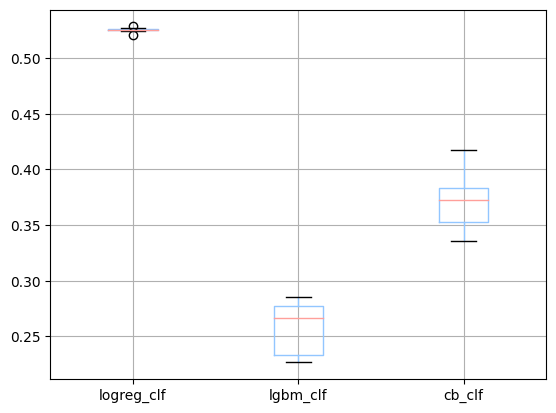

In [103]:
train_scores.boxplot()

<Axes: >

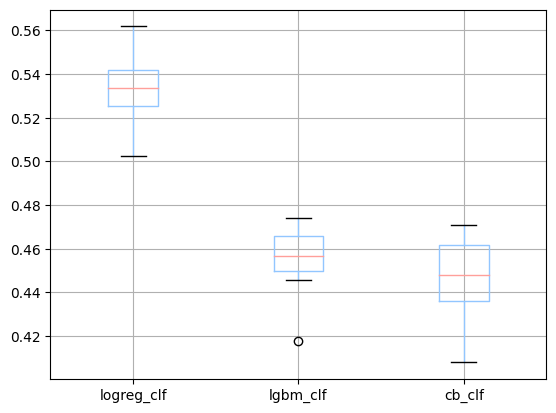

In [104]:
val_scores.boxplot()

CatBoost Classifier gives better results on validation set.

## Submission

In [105]:
final_mod = models[2]['model']

y_test = final_mod.predict_proba(test[cb_feats])

In [106]:
test_ids = test.id
col_names = ['Status_C', 'Status_CL', 'Status_D']
submit = pd.DataFrame({"id":test_ids, **dict(zip(col_names, y_test.T))})
submit.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.312668,0.670181,0.017151
1,7906,0.146759,0.764229,0.089012
2,7907,0.921058,0.044337,0.034605
3,7908,0.065212,0.928426,0.006362
4,7909,0.168772,0.790078,0.041150


In [107]:
from google.colab import drive
drive.mount('/content/drive')

submit.to_csv(('/content/drive/My Drive/Cirrhosis_Outcomes/submission.csv'), index=False)
submit.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,Status_C,Status_CL,Status_D
0,7905,0.312668,0.670181,0.017151
1,7906,0.146759,0.764229,0.089012
2,7907,0.921058,0.044337,0.034605
3,7908,0.065212,0.928426,0.006362
4,7909,0.168772,0.790078,0.041150
